<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/PDPbox_table_data_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NN13 

*PDPbox table data* original Titanic notebook.

In [1]:
!pip search pdpbox | grep INSTALLED || pip install pdpbox

  INSTALLED: 0.2.0 (latest)


In [0]:
%matplotlib inline

import pandas as pd
import numpy as np

import os
import json

In [3]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout
from sklearn.base import BaseEstimator, TransformerMixin

from pdpbox import pdp, get_dataset, info_plots

Using TensorFlow backend.


In [4]:
!kaggle competitions download -w -o titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 56.1MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 24.1MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.87MB/s]


In [0]:
raw_train = pd.read_csv('./train.csv', index_col=0)
raw_train['is_test'] = 0
raw_test = pd.read_csv('./test.csv', index_col=0)
raw_test['is_test'] = 1

In [0]:
all_data = pd.concat((raw_train, raw_test), axis=0)

In [0]:
def get_title_last_name(name):
    full_name = name.str.split(', ', n=0, expand=True)
    last_name = full_name[0]
    titles = full_name[1].str.split('.', n=0, expand=True)
    titles = titles[0]
    return(titles)

def get_titles_from_names(df):
    df['Title'] = get_title_last_name(df['Name'])
    df = df.drop(['Name'], axis=1)
    return(df)

def get_dummy_cats(df):
    return(pd.get_dummies(df, columns=['Title', 'Pclass', 'Sex', 'Embarked',
                                       'Cabin', 'Cabin_letter']))

def get_cabin_letter(df):    
    df['Cabin'].fillna('Z', inplace=True)
    df['Cabin_letter'] = df['Cabin'].str[0]    
    return(df)

def process_data(df):
    # preprocess titles, cabin, embarked
    df = get_titles_from_names(df)    
    df['Embarked'].fillna('S', inplace=True)
    df = get_cabin_letter(df)
    
    # drop remaining features
    df = df.drop(['Ticket', 'Fare'], axis=1)
    
    # create dummies for categorial features
    df = get_dummy_cats(df)
    
    return(df)

proc_data = process_data(all_data)
proc_train = proc_data[proc_data['is_test'] == 0]
proc_test = proc_data[proc_data['is_test'] == 1]

In [8]:
# create model
model = Sequential()
model.add(Dense(input_dim=proc_data.shape[1]-2, units=512,
                 kernel_initializer='normal', bias_initializer='ones'))
model.add(Activation('relu'))

for i in range(0, 3):
    model.add(Dense(units=256, kernel_initializer='normal',
                     bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dropout(0.05))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               115712    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
__________

In [0]:
X = proc_train.drop(['Survived', 'is_test'], axis=1).fillna(-1)
y = proc_train.Survived.fillna(0)

In [11]:
history = model.fit(X, y, verbose=0, epochs=25)

list(enumerate(history.history['loss'], 1))[4::5]

Instructions for updating:
Use tf.cast instead.


[(5, 0.6700636248797278),
 (10, 0.6487239164401652),
 (15, 0.6411174574551224),
 (20, 0.6177730577695785),
 (25, 0.586829736243461)]

In [0]:
pdp_age = pdp.pdp_isolate(
    model=model, dataset=X, model_features=X.columns, feature='Age'
)

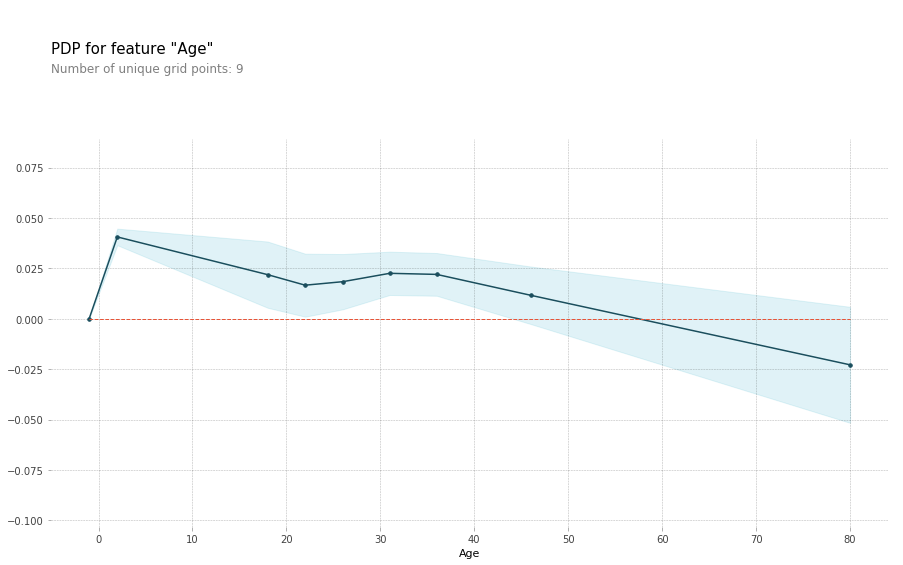

In [13]:
fig, axes = pdp.pdp_plot(pdp_age, 'Age')

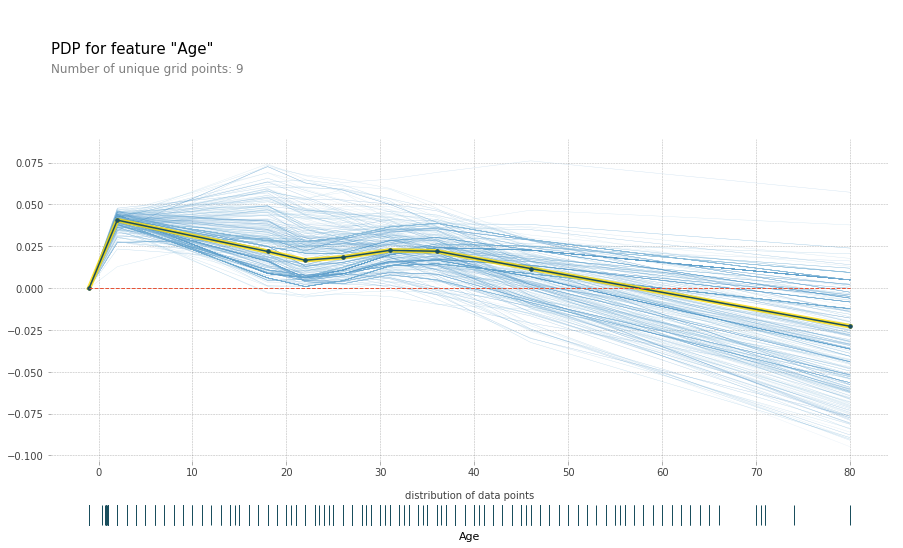

In [14]:
fig, axes = pdp.pdp_plot(pdp_age, 'Age', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

In [0]:
# Workaround 
class skl_model(BaseEstimator, TransformerMixin):
    def __init__(self,model):
        self.model=model
    def predict(self,X,par):
        return self.model.predict(X)

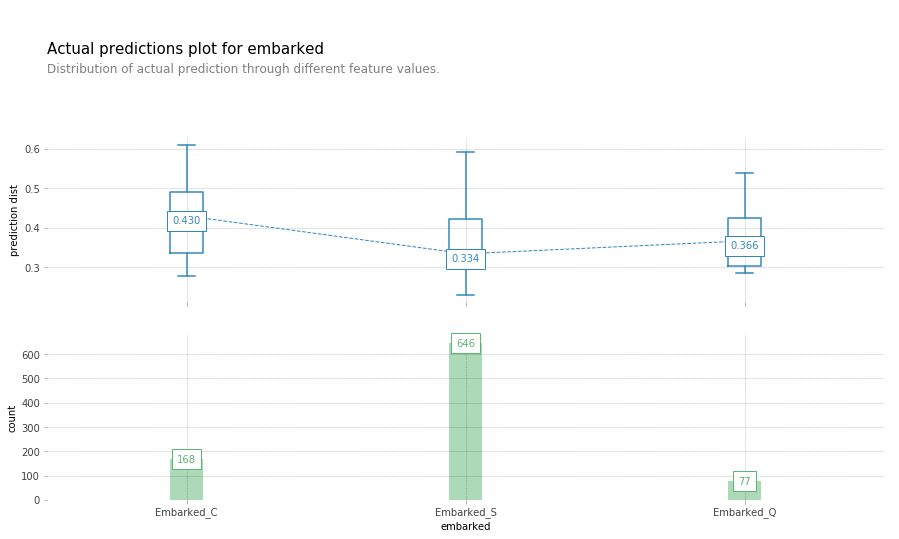

In [16]:
fig, axes, summary_df = info_plots.actual_plot(
    model=skl_model(model), X=X, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'],feature_name='embarked',
    predict_kwds={'par':1}
)

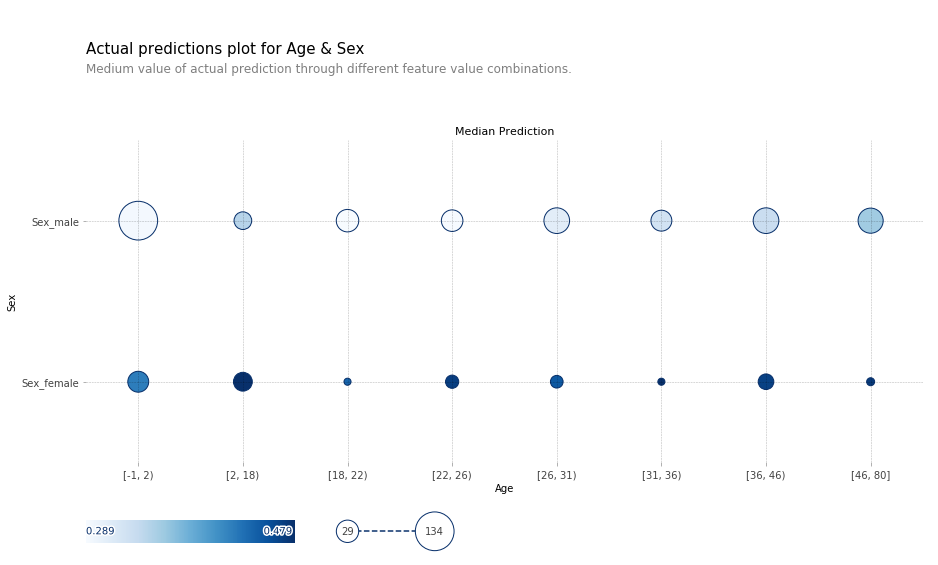

In [17]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=skl_model(model), X=X, features=['Age', ['Sex_female','Sex_male']], feature_names=['Age', 'Sex'],
    predict_kwds={'par':1}
)